In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix

# Load data

In [18]:
# Load data
npz = np.load('./my_comp_train_XY.npz')
X_raw = npz['X']
y_raw = npz['y']

# Scale X data into range 0.0 to 1.0 and flatten image
X_raw = (X_raw / 255.).reshape(-1, 28, 28, 1)
y_raw = y_raw.reshape(-1,1)

In [19]:
# Split data into train and valid set
X_train_org, X_test, y_train_org, y_test = train_test_split(X_raw, y_raw, 
                                                      shuffle=True, test_size=0.25, stratify=y_raw)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_org, y_train_org, 
                                                      shuffle=True, test_size=0.20, stratify=y_train_org)
print("Train data shape, X_train.shape:{} y_train.shape:{}".format(X_train.shape, y_train.shape))
print("Train data shape, X_valid.shape:{} y_valid.shape:{}".format(X_valid.shape, y_valid.shape))
print("Test data shape, X_test.shape:{} y_test.shape:{}".format(X_test.shape, y_test.shape))

Train data shape, X_train.shape:(27285, 28, 28, 1) y_train.shape:(27285, 1)
Train data shape, X_valid.shape:(6822, 28, 28, 1) y_valid.shape:(6822, 1)
Test data shape, X_test.shape:(11370, 28, 28, 1) y_test.shape:(11370, 1)


In [10]:
label_num = len(np.unique(y_train))
print(label_num)

10


# Train/Eval

In [26]:
tf.keras.backend.clear_session()

## Model 1

### Train

In [27]:
# Build model
model_v1 = models.Sequential([
    Conv2D(32, kernel_size=(3,3), activation="relu", padding="same", input_shape=(28, 28, 1)),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3,3), activation="relu", padding="same"),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(label_num, activation="softmax"),
])

In [29]:
# Compile
model_v1.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [28]:
# Summary
model_v1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [31]:
# Train
epochs = 30
batch_size = 128

early_stopping = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model_v1.fit(X_train, y_train,
             validation_data=(X_valid, y_valid),
             epochs=epochs,
             batch_size=batch_size,
             callbacks=[early_stopping]
            )

Epoch 1/30
214/214 [==============================] - 18s 86ms/step - loss: 0.3673 - accuracy: 0.8865 - val_loss: 0.1301 - val_accuracy: 0.9614
Epoch 2/30
214/214 [==============================] - 18s 84ms/step - loss: 0.1087 - accuracy: 0.9664 - val_loss: 0.0737 - val_accuracy: 0.9792
Epoch 3/30
214/214 [==============================] - 18s 85ms/step - loss: 0.0758 - accuracy: 0.9760 - val_loss: 0.0618 - val_accuracy: 0.9827
Epoch 4/30
214/214 [==============================] - 18s 84ms/step - loss: 0.0602 - accuracy: 0.9817 - val_loss: 0.0472 - val_accuracy: 0.9855
Epoch 5/30
214/214 [==============================] - 18s 83ms/step - loss: 0.0488 - accuracy: 0.9850 - val_loss: 0.0432 - val_accuracy: 0.9875
Epoch 6/30
214/214 [==============================] - 19s 87ms/step - loss: 0.0397 - accuracy: 0.9871 - val_loss: 0.0417 - val_accuracy: 0.9880
Epoch 7/30
214/214 [==============================] - 19s 88ms/step - loss: 0.0351 - accuracy: 0.9883 - val_loss: 0.0468 - val_accuracy:

### Evaluate

In [38]:
# Predict
y_pred_train_v1 = np.argmax(model_v1.predict(X_train), axis=1)
y_pred_valid_v1 = np.argmax(model_v1.predict(X_valid), axis=1)
y_pred_test_v1 = np.argmax(model_v1.predict(X_test), axis=1)

In [39]:
# Accuracy score
print("Train accuracy score: \t{}".format(accuracy_score(y_train, y_pred_train_v1)))
print("Valid accuracy score: \t{}".format(accuracy_score(y_valid, y_pred_valid_v1)))
print("Test accuracy score: \t{}".format(accuracy_score(y_test, y_pred_test_v1)))

Train accuracy score: 	0.9939527212754261
Valid accuracy score: 	0.9879800644972149
Test accuracy score: 	0.9842568161829376


In [40]:
# Confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_train_v1)
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid_v1)
conf_matrix_test  = confusion_matrix(y_test,  y_pred_test_v1)

Text(0.5, 1.0, 'Test data')

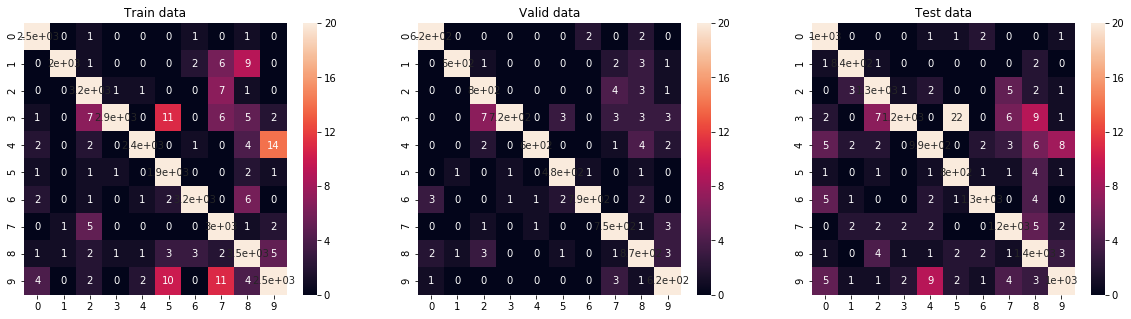

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
sns.heatmap(conf_matrix_train, annot=True, vmin=0, vmax=20, ax=axes[0])
axes[0].set_title("Train data")
sns.heatmap(conf_matrix_valid, annot=True, vmin=0, vmax=20, ax=axes[1])
axes[1].set_title("Valid data")
sns.heatmap(conf_matrix_test, annot=True, vmin=0, vmax=20, ax=axes[2])
axes[2].set_title("Test data")

In [65]:
# Images with wrong prediction
wrong_predict_mask = (y_test.reshape(-1) != y_pred_test_v1)
wrong_predict_indicies = np.where(wrong_predict_mask == True)[0]
print((wrong_predict_indicies).shape)

(179,)


/Users/sampeimasato/.pyenv/versions/anaconda3-2018.12/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


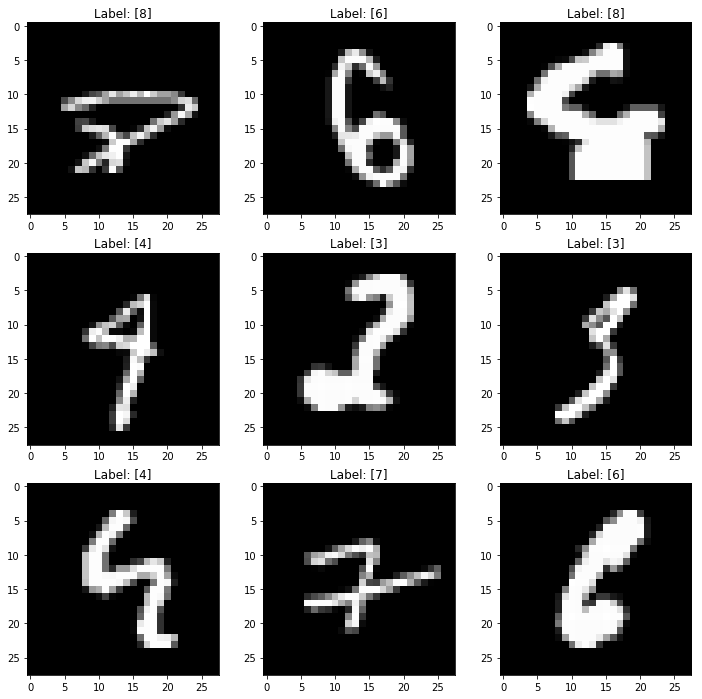

In [82]:
plt.subplots(3, 3, figsize=(12,12))
plt.subplot(3,3,1)

for count, wrong_idx in enumerate(wrong_predict_indicies):
    if count >= 9:
        break
    plt.subplot(3, 3, count + 1)
    plt.imshow(X_test[wrong_idx].reshape(28, 28), cmap="gray")
    plt.title("Label: {}".format(y_test[wrong_idx]))

# Save model

In [85]:
model_v1.save('/Users/sampeimasato/Documents/kaggle/AppFolder/MNISTApp/estimator/cnn_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /Users/sampeimasato/Documents/kaggle/AppFolder/MNISTApp/estimator/cnn_model/assets


In [86]:
model_v1_loaded = tf.keras.models.load_model('/Users/sampeimasato/Documents/kaggle/AppFolder/MNISTApp/estimator/cnn_model')

In [87]:
model_v1_loaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

# Compare with simple neural net and XGBoost

**The accuracy score for XGBoost and Neural net was bellow**<br>
    - XGBoost accuracy:    0.969217238346526
    - Neural net accuracy: 0.9657871591908531
    
Test accuracy for CNN was 0.984 which is 0.2 points higher.<br>
NOTE: Evaluation dataset for XGBoost, NN and CNN are not the same. Therefore this not a precise comparison.